<a href="https://colab.research.google.com/github/sanghongn/audio/blob/main/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.models import load_model
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint

In [72]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)
        self.model_path = os.path.join('/content/drive/MyDrive/models', mode + '.model')
        self.p_path = os.path.join('/content/drive/MyDrive/pickle', mode + '.p')
        
def check_data():
    if os.path.isfile(config.p_path):
        print('loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None
         
        
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y= []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('/content/drive/MyDrive/clean/'+file)
        label = df.at[file,'label']
        #random index of each signal???
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        #take a window of sample
        sample = wav[rand_index: rand_index+config.step]
        #calculate 39 feature each windows??
        #X_sample = mfcc(sample, rate,
                         #numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        X_sample = mfcc(sample, rate,
                       numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        #X.append(X_sample if config.mode == 'conv' else X_sample.T)
        X.append(X_sample)
        y.append(classes.index(label))
    #dont want recalculate when load model
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min)/(_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=10)
    config.data = (X,y)
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol = 2) 
    return X, y
        
        
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3, 3), activation='relu',strides=(1,1),padding='same', input_shape=input_shape))
    model.add(Conv2D(32,(3, 3), activation='relu',strides=(1,1),padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu',strides=(1,1),padding='same', input_shape=input_shape))
    model.add(Conv2D(128, (3,3), activation='relu',strides=(1,1),padding='same', input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'], jit_compile = True)
    return model

def build_predictions(audio_dir):
    y_true = []
    y_pred = []
    fn_prob = {}
    
    print('Extracting feature from audio')
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(os.path.join(audio_dir, fn))
        label = fn2class[fn]
        c = classes.index(label)
        y_prob = []
        
        for i in range(0, wav.shape[0]-config.step, config.step):
            sample = wav[i:i+config.step]
            x = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
            x = (x - config.min)/(config.max - config.min)
            
            if config.mode == 'conv':
                x = x.reshape(1, x.shape[0], x.shape[1], 1)
            elif config.mode == 'time':
                x = np.expand_dims(x, axis=0)
            y_hat = model.predict(x, verbose=0)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
        fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
    return y_true, y_pred, fn_prob

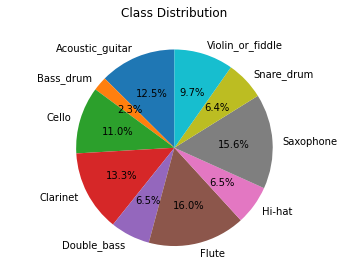

In [73]:
df = pd.read_csv('/content/drive/MyDrive/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('/content/drive/MyDrive/clean/'+f)
    #return a colum contans length of audios
    df.at[f, 'length'] = signal.shape[0]/rate

#create a list of instruments' name
classes = list(np.unique(df.label))
#create length mean of each type
class_dist = df.groupby(['label'])['length'].mean()
t = class_dist.sum()
t2 = df['length'].sum()

n_samples = 2*int(df['length'].sum()/0.1)
#probability of a type in 10 type
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

#plot pie
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()



In [74]:
config = Config(mode = 'conv')
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis = 1)
    input_shape = (X.shape[1], X.shape[2],1)
    model = get_conv_model()

100%|██████████| 26404/26404 [01:32<00:00, 284.66it/s]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 9, 13, 16)         160       
                                                                 
 conv2d_25 (Conv2D)          (None, 9, 13, 32)         4640      
                                                                 
 conv2d_26 (Conv2D)          (None, 9, 13, 64)         18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 9, 13, 128)        73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 4, 6, 128)         0         
                                                      

In [75]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat),y=y_flat)
class_weight = {i:class_weight[i] for i in range(len(class_weight))}

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=0, mode='max', 
                            save_best_only=True,
                            save_weights_only=False, save_freq='epoch')
#model.fit(X, y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight)
model.fit(X, y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight,
           validation_split=0.1, callbacks=[checkpoint])

model.save(config.model_path)

Epoch 1/10
743/743 [==============================] - ETA: 0s - loss: 0.9999 - acc: 0.6182

743/743 [==============================] - 7s 7ms/step - loss: 0.9999 - acc: 0.6182 - val_loss: 0.5773 - val_acc: 0.8027
Epoch 2/10
742/743 [============================>.] - ETA: 0s - loss: 0.5076 - acc: 0.8038

743/743 [==============================] - 4s 5ms/step - loss: 0.5076 - acc: 0.8039 - val_loss: 0.3964 - val_acc: 0.8603
Epoch 3/10
739/743 [============================>.] - ETA: 0s - loss: 0.3591 - acc: 0.8622

743/743 [==============================] - 5s 7ms/step - loss: 0.3588 - acc: 0.8622 - val_loss: 0.2793 - val_acc: 0.9016
Epoch 4/10
743/743 [==============================] - 4s 5ms/step - loss: 0.2865 - acc: 0.8899 - val_loss: 0.2761 - val_acc: 0.9012
Epoch 5/10
743/743 [==============================] - ETA: 0s - loss: 0.2448 - acc: 0.9068

743/743 [==============================] - 7s 9ms/step - loss: 0.2448 - acc: 0.9068 - val_loss: 0.2513 - val_acc: 0.9129
Epoch 6/10
732/743 [============================>.] - ETA: 0s - loss: 0.2010 - acc: 0.9197

743/743 [==============================] - 5s 7ms/step - loss: 0.2012 - acc: 0.9197 - val_loss: 0.2287 - val_acc: 0.9186
Epoch 7/10
727/743 [============================>.] - ETA: 0s - loss: 0.1936 - acc: 0.9260

743/743 [==============================] - 4s 5ms/step - loss: 0.1928 - acc: 0.9264 - val_loss: 0.1795 - val_acc: 0.9379
Epoch 8/10
733/743 [============================>.] - ETA: 0s - loss: 0.1723 - acc: 0.9349

743/743 [==============================] - 3s 5ms/step - loss: 0.1721 - acc: 0.9349 - val_loss: 0.1608 - val_acc: 0.9451
Epoch 9/10
728/743 [============================>.] - ETA: 0s - loss: 0.1546 - acc: 0.9395

743/743 [==============================] - 4s 5ms/step - loss: 0.1547 - acc: 0.9395 - val_loss: 0.1605 - val_acc: 0.9496
Epoch 10/10
728/743 [============================>.] - ETA: 0s - loss: 0.1474 - acc: 0.9427

743/743 [==============================] - 4s 5ms/step - loss: 0.1471 - acc: 0.9426 - val_loss: 0.1372 - val_acc: 0.9576


In [76]:
# process predict data
df = pd.read_csv('/content/drive/MyDrive/instruments.csv')
classes = list(np.unique(df.label))
fn2class = dict(zip(df.fname, df.label))
p_path = os.path.join('/content/drive/MyDrive/pickle/', 'conv.p')

with open(p_path,'rb') as handle:
    config = pickle.load(handle)
    
model = load_model(config.model_path)

y_true, y_pred, fn_prob = build_predictions('/content/drive/MyDrive/clean/')
acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)

y_probs =[]
for i, row in df.iterrows():
    y_prob = fn_prob[row.fname]
    y_probs.append(y_prob)
    for c, p in zip(classes, y_prob):
        df.at[i,c] = p
        
y_pred = [classes[np.argmax(y)] for y in y_probs]
df['y_pred'] = y_pred
df.to_csv('prediction.csv', index=False)

Extracting feature from audio


100%|██████████| 300/300 [08:36<00:00,  1.72s/it]
